In [1]:
import numpy as np
import scipy
import matplotlib as mplt
from matplotlib import pyplot as plt
import sympy as sp
from sympy import *
from scipy.optimize import fsolve
from scipy.optimize import bisect
from IPython.display import display, Latex
import mpl_toolkits.mplot3d.axes3d as axes3d

In [45]:
G=6.674E-11 # m^3 kg^-1 s^-2
Ms=5.683E+26 #Saturn's mass in kg
Rs=60268*1e3 # Saturn's radius in m
Gamma=1
R_dring=Rs+3000*1e3#1.0498*Rs#1.110*Rs#66900 # D ring inner radius in m
R_grain0=10e-9 # Ice grain radius in m
rho_m_mass=1e3 #grain density (water) in kg/m^3
m00=rho_m_mass*4/3* np.pi* R_grain0**3
M=18.01528e-3 #molecular weight of water, kg/mol
NA=6.022e23
n=NA/M *rho_m_mass
rho_m=n
M_H2=2.016e-3 #molecular weight of H_2, kg/mol

q_e=1.60217663e-19 #electron charge in C
Q=-10.15*q_e
Mom=4.6e+18*0 #T*m^3
B0=21*1e-6
dt=0.01
t=np.arange(0,5000,dt)
N=len(t)

"Initial conditions"
pos_init = np.array([R_dring, np.deg2rad(90), 0]) #r_0, θ_0, φ_0

v_kep=np.sqrt(G*Ms/pos_init[0])
v_init_cart = np.array([-40*1e3, 0, 0])

v_init_sph = np.array([v_init_cart[0]*np.sin(pos_init[1])*np.cos(pos_init[2])+v_init_cart[1]*np.sin(pos_init[1])*np.sin(pos_init[2])+v_init_cart[2]*np.cos(pos_init[1]),
                       v_init_cart[0]*np.cos(pos_init[1])*np.cos(pos_init[2])+v_init_cart[1]*np.cos(pos_init[1])*np.sin(pos_init[2])-v_init_cart[2]*np.sin(pos_init[1]),
                      -v_init_cart[0]*np.sin(pos_init[2])+v_init_cart[1]*np.cos(pos_init[2])])

vr0=v_init_sph[0]; vth0=v_init_sph[1]; vphi0=v_init_sph[2]
#if vr0<0.001: vr0=0
pos_der_init = np.array([vr0, vth0/pos_init[0], vphi0/(pos_init[0]*np.sin(pos_init[1]))])
v_init_sph


array([-4.0000000e+04, -2.4492936e-12,  0.0000000e+00])

In [39]:
## capacitance of sphere is C= 4*pi*eps_0*r (assume rel perm ≈ 1)
## charge is Q=C*U
amu=1.67e-27; ## 1 amu in kg
dens=1000; #mass density of water kg/m^3
rmic=R_grain0/(1e-6); #radius expressed in micrometer
eps0=8.854e-12;  #vacuum permittivity
C=4*np.pi*eps0*R_grain0;  #capacitance
U=-6.15;  # assumed magnitude of grain potential (change as you wish!)
Q_grain=C*U; #grain charge
charges=(Q_grain/q_e); #grain charge in terms of number of charges
mass=((4/3)*np.pi*(R_grain0)**3)*dens; #mass of grain calculated as volume times density
massAMU=mass/amu; # mass expressed in amu
qoverm=charges/massAMU #q/m in charges per amu
qm_SI=Q_grain/mass
Alternative=(1.683e-9)*(U/6)/(rmic**2) #q/m according to Ip et al but with a possible typo correction, I think their phi_v = U/6V  (this is dimensionless)
print('From the code:', Q/m00,'C/kg  or  ',Q/m00 * (amu/q_e), ' e/amu' '\nqm_SI (Ip et al.):', qm_SI, '\nQ_tot:',charges, '\nq/m (Ip):',qoverm, '\nAlternative',Alternative)
Qtom=qm_SI
qoverm

From the code: -388.2288679895653 C/kg  or   -4.046633794318758e-06  e/amu
qm_SI (Ip et al.): -1633.5629999999996 
Q_tot: -42.70847898525065 
q/m (Ip): -1.7027150183809634e-05 
Alternative -1.725075e-05


-1.7027150183809634e-05

In [40]:
from functions import gravity, rho_a, drag, acc_RHS, vel_RHS, temp, mass, magnetic

def RK4(dt, pos, pos_der, G, Ms, rho_m, R_grain, Gamma, Q, m, Mom, B0, Qtom):
    
    k1r=vel_RHS(pos, pos_der)
    k1v=acc_RHS(pos, pos_der) + gravity(G,Ms,pos, pos_der) + drag(Gamma, rho_m, rho_a(pos, pos_der), R_grain, pos, pos_der) + \
        magnetic(Mom, B0, Q, m, pos, pos_der, Qtom)[0] + magnetic(Mom, B0, Q, m, pos, pos_der, Qtom)[1]

    k2r=vel_RHS(pos+0.5*dt*k1r, pos_der+0.5*dt*k1v)
    
    k2v=acc_RHS(pos+0.5*dt*k1r, pos_der+0.5*dt*k1v) + gravity(G,Ms, pos+0.5*dt*k1r, pos_der+0.5*dt*k1v) + \
        drag(Gamma, rho_m, rho_a(pos+0.5*dt*k1r, pos_der+0.5*dt*k1v), R_grain, pos+0.5*dt*k1r, pos_der+0.5*dt*k1v) + \
        magnetic(Mom, B0, Q, m, pos+0.5*dt*k1r, pos_der+0.5*dt*k1v, Qtom)[0] + magnetic(Mom, B0, Q, m, pos+0.5*dt*k1r, pos_der+0.5*dt*k1v, Qtom)[1]

    k3r=vel_RHS(pos+0.5*dt*k2r, pos_der+0.5*dt*k2v)
    
    k3v=acc_RHS(pos+0.5*dt*k2r, pos_der+0.5*dt*k2v) + gravity(G,Ms, pos+0.5*dt*k2r, pos_der+0.5*dt*k2v) + \
        drag(Gamma, rho_m, rho_a(pos+0.5*dt*k2r, pos_der+0.5*dt*k2v), R_grain, pos+0.5*dt*k2r, pos_der+0.5*dt*k2v) + \
        magnetic(Mom, B0, Q, m, pos+0.5*dt*k2r, pos_der+0.5*dt*k2v, Qtom)[0] + magnetic(Mom, B0, Q, m, pos+0.5*dt*k2r, pos_der+0.5*dt*k2v, Qtom)[1]

    k4r=vel_RHS(pos+dt*k3r, pos_der+dt*k3v)
    
    k4v=acc_RHS(pos+dt*k3r, pos_der+dt*k3v) + gravity(G,Ms, pos+dt*k3r, pos_der+dt*k3v) + \
        drag(Gamma, rho_m, rho_a(pos+dt*k3r, pos_der+dt*k3v), R_grain, pos+dt*k3r, pos_der+dt*k3v) + \
        magnetic(Mom, B0, Q, m, pos+dt*k3r, pos_der+dt*k3v, Qtom)[0] + magnetic(Mom, B0, Q, m, pos+dt*k3r, pos_der+dt*k3v, Qtom)[1]

    pos_new=pos + dt/6 * (k1r+2*k2r+2*k3r+k4r)
    pos_der_new=pos_der + dt/6 * (k1v+2*k2v+2*k3v+k4v)

    return np.array([pos_new, pos_der_new])


In [41]:
%%time
"SOLVER"

r = []; th=[]; phi=[]
v_r=[]; v_theta=[]; v_phi=[]; vtot=[];

state=np.array([[pos_init],[pos_der_init]])
pos=pos_init; pos_der=pos_der_init

a_gr=[]; a_drag=[]; a_mag=[]; a_Ec=[]
T=[]; m=[]; R_grain=[]
m0=m00
for i in range(1,N):        
    r.append(pos[0]); th.append(pos[1]); phi.append(pos[2])
    v_r.append(pos_der[0]); v_theta.append(r[i-1]*pos_der[1]); v_phi.append(r[i-1]*np.sin(th[i-1])*pos_der[2])
    vtot.append(np.sqrt(v_r[i-1]**2+v_theta[i-1]**2+v_phi[i-1]**2)*1e-3)

    T.append(temp(vtot[i-1]*1e3, rho_a(pos, pos_der) *M_H2/NA))
    m.append(mass(rho_m_mass, T[i-1], m0, i, dt))
    m0=m[i-1]
    
    if m[i-1]<=0:
        print('particle sublimated',m[i-1], T[i-1])
        m.pop(); T.pop(); 
        r.pop(); th.pop(); phi.pop()
        v_r.pop(); v_theta.pop(); v_phi.pop()
        vtot.pop()
        break
    
    R_grain.append((3/(4*np.pi) *m[i-1]/rho_m_mass)**(1/3))
    
    a_gr.append(np.linalg.norm(gravity(G, Ms, pos, pos_der))*1e-3); 
    a_drag.append(np.linalg.norm(drag(Gamma, rho_m, rho_a(pos, pos_der), R_grain[i-1], pos, pos_der)*np.array([1, r[i-1], r[i-1]*np.sin(th[i-1])]))*1e-3)
    a_Ec.append(np.linalg.norm(magnetic(Mom, B0, Q, m[i-1], pos, pos_der, Qtom)[0]*np.array([1, r[i-1], r[i-1]*np.sin(th[i-1])]))*1e-3)
    a_mag.append(np.linalg.norm(magnetic(Mom, B0, Q, m[i-1], pos, pos_der, Qtom)[1]*np.array([1, r[i-1], r[i-1]*np.sin(th[i-1])]))*1e-3)
    
    if r[i-1]<=Rs: 
        print('particle fell into the planet')
        break
    # if vtot[i-1]<=0.1: 
    #     print('particle velocity close to 0')
    #     break
    
    state = RK4(dt, pos, pos_der, G, Ms, rho_m, R_grain[i-1], Gamma, Q, m[i-1], Mom, B0, Qtom)
    pos=state[0]; pos_der=state[1]
    

particle sublimated [-1.37372334e-18] [211.45577603]
CPU times: total: 31.2 ms
Wall time: 36 ms


C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


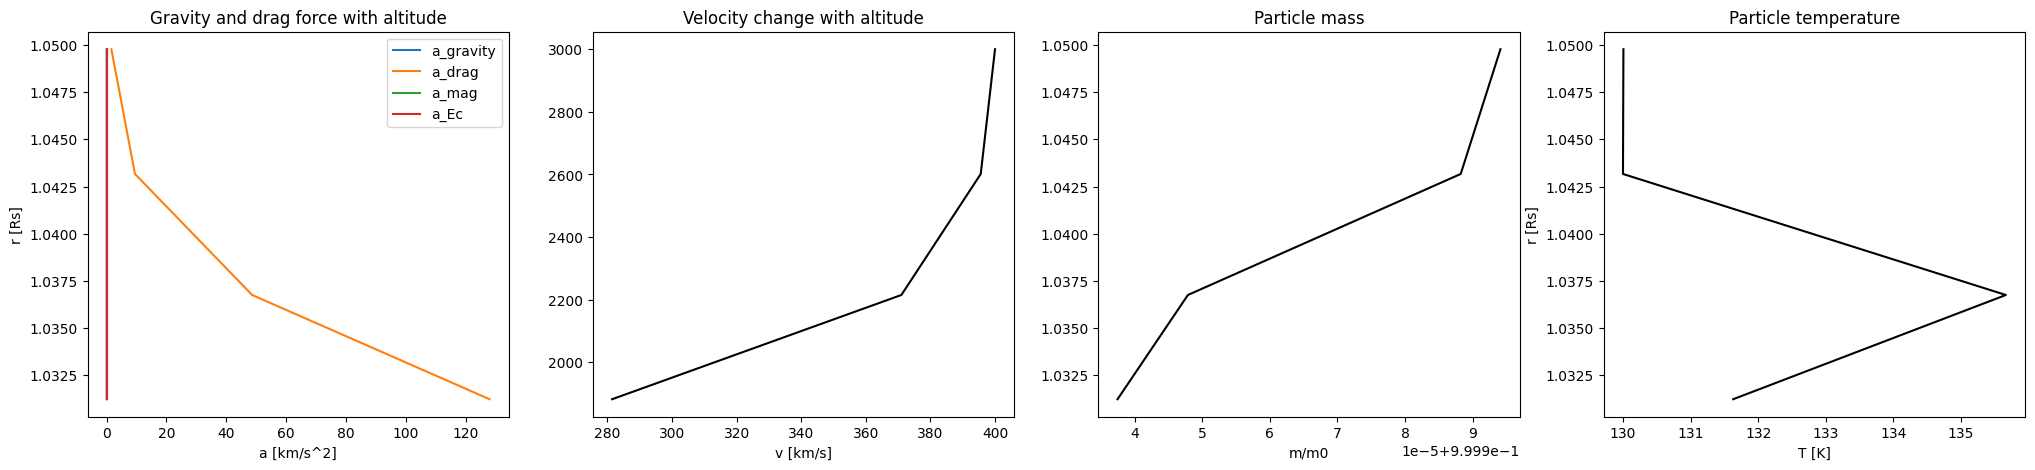

In [42]:
# using the variable axs for multiple Axes
fig, axs = plt.subplots(1, 4, figsize=(25,5))

axs[0].plot(a_gr,np.array(r[0:len(a_gr)])/Rs, label='a_gravity')
axs[0].plot(a_drag,np.array(r[0:len(a_drag)])/Rs, label='a_drag')
axs[0].plot(a_mag,np.array(r[0:len(a_mag)])/Rs, label='a_mag')
axs[0].plot(a_Ec,np.array(r[0:len(a_Ec)])/Rs, label='a_Ec')

axs[0].set_title('Gravity and drag force with altitude')
axs[0].legend()
axs[0].set_xlabel('a [km/s^2]')
axs[0].set_ylabel('r [Rs]')

axs[1].plot(vtot,(np.array(r)/Rs* Rs-Rs)*1e-3,'k')
axs[1].set_title('Velocity change with altitude')
axs[1].set_xlabel('v [km/s]')

axs[2].plot(np.array(m)/m00, np.array(r[0:len(m)])/Rs,'k')
axs[2].set_title('Particle mass')
#axs[2].invert_xaxis()
axs[2].set_xlabel('m/m0')

axs[3].plot(T,np.array(r[0:len(T)])/Rs,'k')
axs[3].set_title('Particle temperature')
axs[3].set_xlabel('T [K]')
axs[3].set_ylabel('r [Rs]')

fig.savefig('results', dpi='figure')

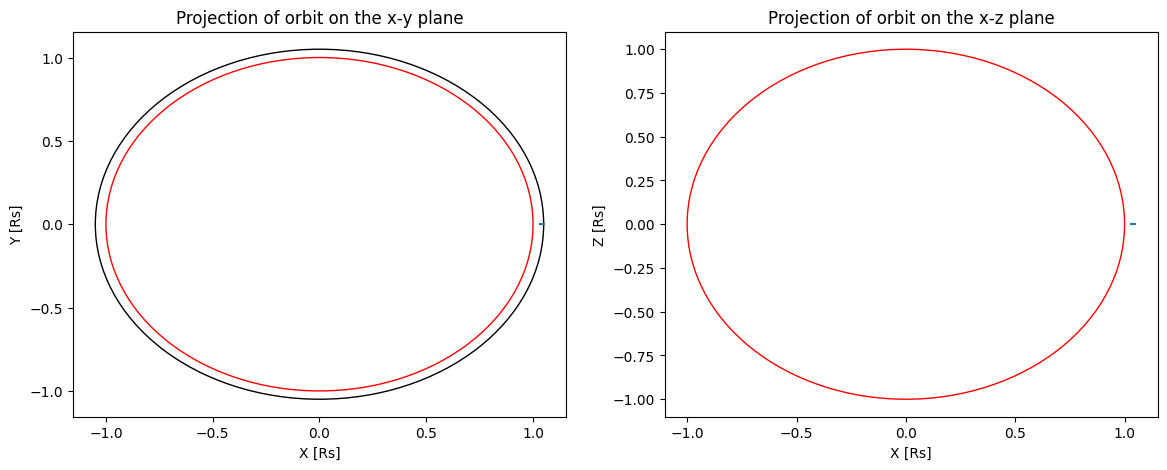

In [43]:
x=r*np.sin(th)*np.cos(phi)#-np.cos(phi)*2*np.pi/(10.2245*60*60)*np.array(r)*np.array(t[0:len(r)])
y=r*np.sin(th)*np.sin(phi)#+np.sin(phi)*2*np.pi/(10.2245*60*60)*np.array(r)*t[0:len(r)]
z=r*np.cos(th)#-2*np.pi/(10.2245*60*60)*np.array(r)*t[0:len(r)]

perp=r*np.sin(th)

Sat_xy=plt.Circle((0,0),Rs/Rs, color='r',fill=False)
Sat_xz=plt.Circle((0,0),Rs/Rs, color='r',fill=False)

ring=plt.Circle((0,0),R_dring/Rs, color='k',fill=False)

# using the variable axs for multiple Axes
fig, axs = plt.subplots(1, 2, figsize=(14,5))

axs[0].plot((x)/Rs,y/Rs,'-')
axs[0].add_patch(Sat_xy)
axs[0].add_patch(ring)
#axs[0].set_xlim([-3, 3])
#axs[0].set_ylim([-3, 3])
axs[0].set_title('Projection of orbit on the x-y plane')
axs[0].set_xlabel('X [Rs]')
axs[0].set_ylabel('Y [Rs]')

axs[1].plot(x/Rs,z/Rs,'-')
axs[1].add_patch(Sat_xz)
axs[1].set_title('Projection of orbit on the x-z plane')
axs[1].set_xlabel('X [Rs]')
axs[1].set_ylabel('Z [Rs]')
#axs[1].set_ylim([-1.5,0])
#axs[1].set_xlim([-1.5,0])
fig.savefig('motion_sph', dpi='figure')


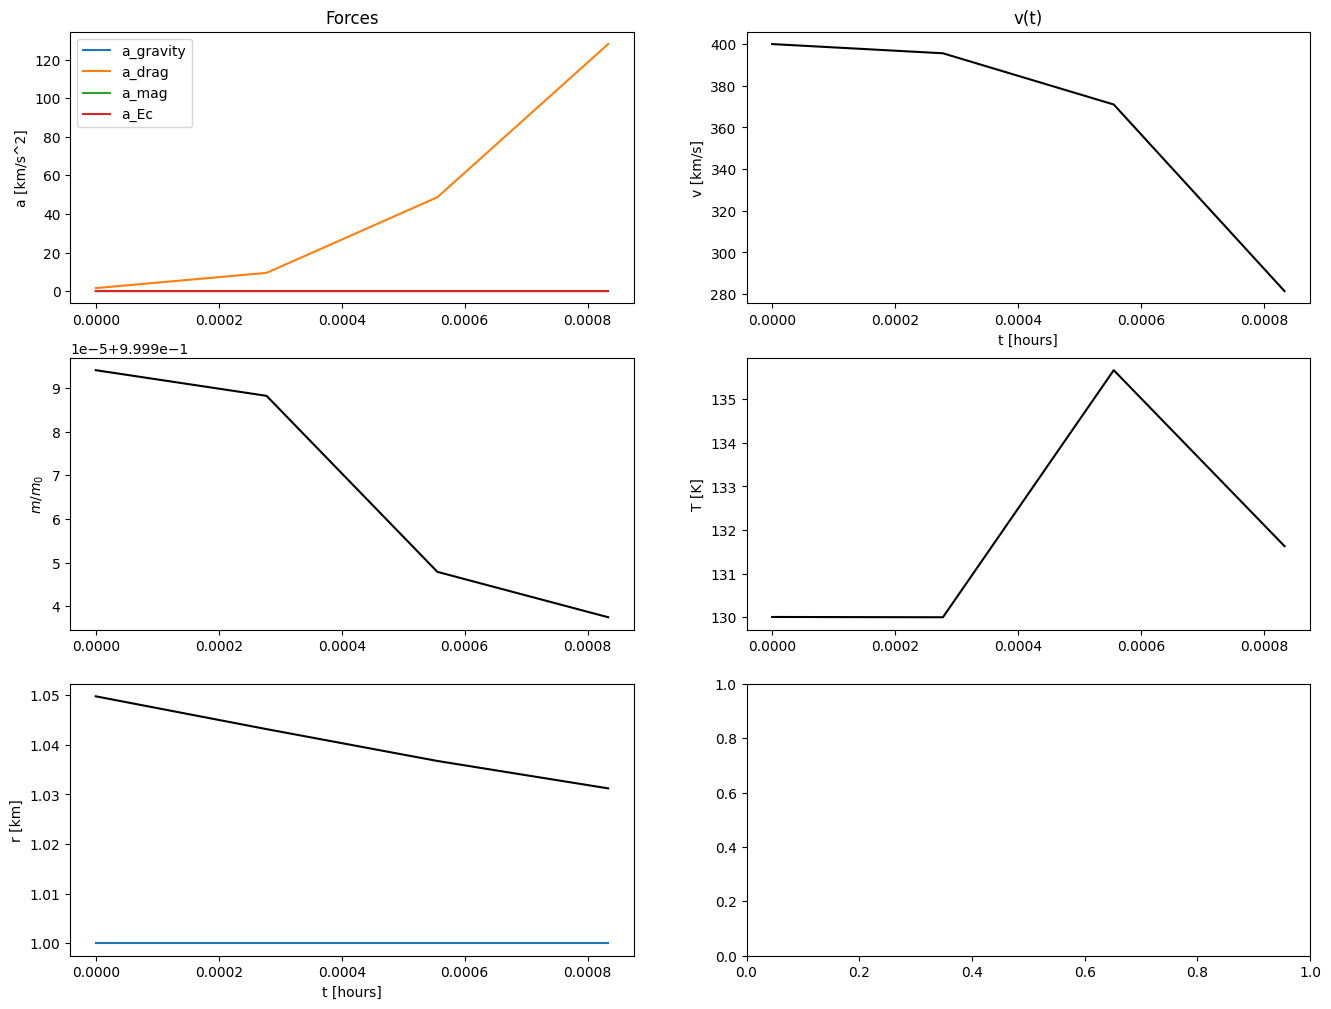

In [44]:
# using the variable axs for multiple Axes
fig, axs = plt.subplots(3, 2, figsize=(16,12))

axs[0,0].plot(np.array(t[0:len(a_gr)])/(60*60), a_gr, label='a_gravity')
axs[0,0].plot(np.array(t[0:len(a_drag)])/(60*60), a_drag, label='a_drag')
axs[0,0].plot(np.array(t[0:len(a_mag)])/(60*60), a_mag, label='a_mag')
axs[0,0].plot(np.array(t[0:len(a_Ec)])/(60*60), a_Ec, label='a_Ec')

axs[0,0].set_title('Forces')
axs[0,0].legend()
#axs[0,0].set_xlabel('t [hours]')
axs[0,0].set_ylabel('a [km/s^2]')

axs[0,1].plot(np.array(t[0:len(vtot)])/(60*60), vtot, 'k')
axs[0,1].set_title('v(t)')
axs[0,1].set_ylabel('v [km/s]')
axs[0,1].set_xlabel('t [hours]')

axs[1,0].plot(np.array(t[0:len(m)])/(60*60), np.array(m)/m00, 'k')
#axs[1,0].set_title('m(t)')
#axs[2].invert_10xaxis()
axs[1,0].set_ylabel('$m/m_0$')
#axs[1,0].set_xlabel('t [hours]')

axs[1,1].plot(np.array(t[0:len(T)])/(60*60), T, 'k')
#axs[1,1].set_title('T(t)')
#axs[1,1].set_xlabel('t [hours]')
axs[1,1].set_ylabel('T [K]')

axs[2,0].plot(np.array(t[0:len(r)])/(60*60), np.array(r)/Rs, 'k')
axs[2,0].set_ylabel('r [km]')
axs[2,0].plot(np.array(t[0:len(r)])/(60*60), np.linspace(1, 1,len(r) ))
axs[2,0].set_xlabel('t [hours]')

fig.savefig('results_time', dpi='figure')

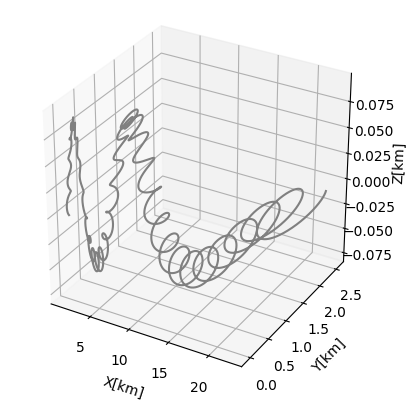

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
plot = ax.plot3D(x/Rs,y/Rs,z/Rs, 'gray')
ax.set_xlabel('X[km]'); ax.set_ylabel('Y[km]'); ax.set_zlabel('Z[km]')
ax.set_box_aspect([1,1,1])
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:40j]
X = Rs*np.cos(u)*np.sin(v)
Y = Rs*np.sin(u)*np.sin(v)
Z = Rs*np.cos(v)
#ax.plot_surface(X, Y, Z, color="r")
plt.show()


In [9]:
m00

4.188790204786391e-21

In [19]:
m[4000][0]

4.188790204763685e-21

In [306]:
G*Ms/R_dring**2

5.327632110400006

In [307]:
R_dring

84375200.0

In [308]:
Q/m00 *np.linalg.norm(v_init_sph)*Mom/(Rs**3)

-5.087435684901197

In [309]:
Q/m00 *1.707e-4*R_dring*B0

-3.4451676791812464